## Import 

In [1]:
from openvino.runtime import Core
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

## 1.Data

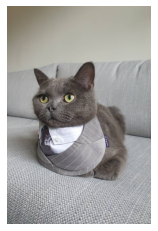

In [2]:
original_image = mpimg.imread('neymar.jpeg')
plt.axis('Off')
plt.imshow(original_image)
plt.show()

## 2.Model
We use omz_downloader, which is a command-line tool from the openvino-dev package. omz_downloader automatically creates a directory structure and downloads the selected model. This step is skipped if the model is already downloaded. The selected model comes from the public directory, which means it must be converted into Intermediate Representation (IR).

If you want to download another model (ssdlite_mobilenet_v2, ssd_mobilenet_v1_coco, ssd_mobilenet_v2_coco, ssd_resnet50_v1_fpn_coco, ssd_mobilenet_v1_fpn_coco) , please change the model name. Note: Using a model outside the list can require different pre- and post-processing.

### Download 

In [3]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "ssdlite_mobilenet_v2"

download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

################|| Downloading ssdlite_mobilenet_v2 ||################

========== Downloading model\public\ssdlite_mobilenet_v2\ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
... 2%, 1024 KB, 780 KB/s, 1 seconds passed
... 4%, 2048 KB, 1248 KB/s, 1 seconds passed
... 6%, 3072 KB, 1855 KB/s, 1 seconds passed
... 8%, 4096 KB, 2299 KB/s, 1 seconds passed
... 10%, 5120 KB, 2825 KB/s, 1 seconds passed
... 12%, 6144 KB, 3361 KB/s, 1 seconds passed
... 14%, 7168 KB, 3855 KB/s, 1 seconds passed
... 16%, 8192 KB, 3942 KB/s, 2 seconds passed
... 18%, 9216 KB, 4403 KB/s, 2 seconds passed
... 20%, 10240 KB, 4855 KB/s, 2 seconds passed
... 22%, 11264 KB, 5042 KB/s, 2 seconds passed
... 24%, 12288 KB, 5461 KB/s, 2 seconds passed
... 26%, 13312 KB, 5836 KB/s, 2 seconds passed
... 28%, 14336 KB, 5595 KB/s, 2 seconds passed
... 30%, 15360 KB, 5958 KB/s, 2 seconds passed
... 32%, 16384 KB, 6318 KB/s, 2 seconds passed
... 34%, 17408 KB, 6631 KB/s, 2 seconds passed
... 36%, 18432 KB, 6819 KB/s, 2 seconds pa

### Convert the Model
The pre-trained model is in TensorFlow format. To use it with OpenVINO, we need to convert it to OpenVINO IR format. To do this, we use Model Converter (omz_converter), which is another command-line tool from the openvino-dev package. If we don't specify a precision, the model will be converted many times to all available precisions (FP32 and FP16 in this case). Every conversion should take up to 2 minutes. If the model has been already converted, this step is skipped. Note: Each model may have different precisions available

In [ ]:
precision = "FP16"

# output path for the conversion
converted_model_path = f"model/public/{model_name}/{precision}/{model_name}.xml"

if not os.path.exists(converted_model_path):
    convert_command = f"omz_converter " \
                      f"--name {model_name} " \
                      f"--download_dir {base_model_dir} " \
                      f"--precisions {precision}"
    ! $convert_command

## 3.App

Firstly, we list all available classes and create colors for them. Then, in the post-process stage, we transform boxes with normalized coordinates [0, 1] into boxes with pixel coordinates [0, image_size_in_px]. Afterward, we use non-maximum suppression to reject overlapping detections and those below the probability threshold (0.5). Finally, we draw boxes and labels inside them.

We need to handle:
- class definition
- function
  - openvino runtime
  - results process
  - draw boxes 
  - object detection
  - image show

In [ ]:
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

In [ ]:
def openvino_runtime(model_xml):
    core = Core()
    model = core.read_model(model_xml)
    compiled_model = core.compile_model(model=model, device_name='AUTO')
    input_layer = compiled_model.input(0)
    output_layer = compiled_model.output(0)
    height, width = list(input_layer.shape)[1:3]
    
    return width, height, compiled_model, output_layer

In [ ]:
def results_handle(frame, results, prob_thresh=0.6):
    h, w = frame.shape[:2]
    results = results.squeeze()
    boxes = []
    labels = []
    scores = []
    for _, label, score, xmin, ymin, xmax, ymax in results:
        boxes.append(
            tuple(map(int, (xmin*w, ymin*h, (xmax-xmin)*w, (ymax-ymin)*h)))
        )
        labels.append(int(label))
        scores.append(float(score))
    # apply non-maximum suppression to get rid of many overlapping entities
    # see https://paperswithcode.com/method/non-maximum-suppression
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=prob_thresh, nms_threshold=0.6
    )
    if len(indices) == 0:
        return []
    # filter detected objects
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]

In [ ]:
def draw_boxes(frame, boxes, target, print_info=False):
    green = (0, 255, 0)
    for label, score, box in boxes:
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        if print_info:
            print(label, score, box)
        if label == classes.index(target):
            cv2.rectangle(img=frame, pt1=box[:2], pt2=(x2, y2), color=green, thickness=5)
            cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] - 10, box[1] - 20),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000 * 1.5,
            color=green,
            thickness=3,
            lineType=cv2.LINE_AA,
            )
    return frame

In [ ]:
def object_detection_demo(frame, width, height, compiled_model, output_layer, classifier):
    input_img = cv2.resize(src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA)
    input_img = np.expand_dims(input_img, axis=0)
    results = compiled_model([input_img])[output_layer]
    boxes = results_handle(frame, results=results)
    frame = draw_boxes(frame, boxes, target=classifier)

In [ ]:
def show(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [ ]:
w, h, model, out_layer = openvino_runtime(converted_model_path)

neymar = cv2.imread('neymar.jpeg')

object_detection_demo(neymar, w, h, model, out_layer, 'cat')

show(neymar)

In [ ]:
neymar = cv2.cvtColor(neymar, cv2.COLOR_BGR2RGB)
im = Image.fromarray(neymar)
im.save("object_detection_cat.jpg")